In [1]:
import keras

Using TensorFlow backend.


In [2]:
from Models.functions.plot import plot_history, full_multiclass_report

In [9]:
from keras.layers import Activation, Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.models import Model, Sequential
from Models.functions.preprocessing import clean, labelEncoder
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
import numpy as np
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import pandas as pd
result = pd.DataFrame()

In [4]:
def create_model(filters = [100], kernel_size = [50], strides = [100], 
                 dropout_rate = 0.5, pool_size = [5], dense_units = 100, max_len = 1000):

    model = Sequential()

    # conv 1
    model.add(Conv1D(filters = filters[0], 
                     kernel_size = kernel_size[0],
                     strides = strides[0], 
                     activation = 'relu', 
                     input_shape = (max_len, 1) ))

    # pooling layer 1
    for i in range(len(pool_size)):
        model.add(MaxPooling1D(pool_size = pool_size[i], strides = 1))
        model.add(Activation('relu'))
    
    #model.add(Activation('relu'))
    
    model.add(Flatten())
    
    if dropout_rate is not None:
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(units = dense_units, activation = 'relu'))
    model.add(Dense(units = 3, activation = 'softmax'))

    model.compile(optimizer = 'adadelta', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [5]:
def get_results(model, y_espected, y_predicted):

    config = model.get_config()

    row = {}

    conv_layers = np.sum([1 if i['class_name'] == "Conv1D" else 0 for i in config])
    pooling_layers = np.sum([1 if i['class_name'] == "MaxPooling1D" else 0 for i in config])

    row.update({ '_accuracy': accuracy_score(y_espected, y_predicted) })
    row.update({ '_f1-score': f1_score(y_espected, y_predicted,average='weighted')})
    row.update({ 'conv_layers': conv_layers })
    row.update({ 'pooling_layers': pooling_layers })

    _, _, fscore, support = precision_recall_fscore_support(y_espected, y_predicted)

    [row.update({'_fscore_class_'+str(i[0]): i[1]}) for i in enumerate(fscore)]
    [row.update({'_support_class_'+str(i[0]): i[1]}) for i in enumerate(support)]

    idx = 1
    for i in config:
        if i['class_name'] == "Conv1D":
            j = str(idx)
            row.update({
                'filters_'+j: i['config']['filters'],
                'strides_'+j: i['config']['strides'],
                'kernel_size_'+j: i['config']['kernel_size'],
                'activation_'+j: i['config']['activation']
            })
        pass
    return row

In [44]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

class Vectorizer(TransformerMixin):
    def __init__(self, max_features = None):
        self.vect = TfidfVectorizer(max_features=max_features)
        
    def reshape(X): return np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    def fit_transform(self, X): return reshape(self.vect_fit_transform(X).toarray())
    
    def transform(self, X): return reshape(self.vect.transform(X).toarray())        
    
    def fit(self, X): return self.vect_fit(X)
    
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import collections, numpy

# Synthetic Minority Oversampling Technique (SMOTE)
def oversampling(X, y):
    X_resampled, y_resampled = SMOTE().fit_resample(X, y)
    return X_resampled, y_resampled


In [45]:
from Models.functions.datasets import loadTrainTest
X, _, y, _ = loadTrainTest(task="gender", dataset_name="brblogset", 
                                                 root="/home/rafael/Dataframe/",
                                                 lang="pt")

y, n, classes_names = labelEncoder(y)

In [46]:
vect = TfidfVectorizer(max_features=10)

vect.fit(X)

vocab_length = len(vect.vocabulary_)

X = vect.transform(X)

### Normalizer

In [43]:
"""
X_resampled, y_resampled = oversampling(X, y)

scaler = StandardScaler(with_mean=False).fit(X.toarray())
m = scaler.transform(X.toarray())

collections.Counter(y_train), collections.Counter(y_resampled), m.shape

xid, yid = 10, 222
plt.scatter(x_train[:,xid], x_train[:,yid],c=y_train)
"""

(Counter({0: 680, 1: 984}), Counter({0: 1241, 1: 1241}), (2081, 10))

In [47]:
from time import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

CNN = KerasClassifier(build_fn=create_model, 
                epochs=1,
                #max_len=x_train[1],
                #batch_size=BATCH_SIZE,
                verbose=0,
                validation_split=0.1
                )

params_grid = dict(
        vect__max_features = [100],
        #cnn__filters = [[40],[60],[50]],
        #cnn__kernel_size = [[50]],
        #cnn__strides = [[2],[4],[6],[8]],
        #cnn__dropout_rate = [0.5,0.1,0.6],
        #cnn__pool_size = [[16,2],[16],[8,2],[8]],
        #cnn__epochs = [50]
        #batch_size = 100
)     

pipeline = Pipeline([
    ( 'vect', Vectorizer),    
    ( 'cnn', CNN)
    ])
                          

grid_search = GridSearchCV(pipeline, 
                           params_grid, 
                           scoring='accuracy', cv=3, 
                           return_train_score=True
                           )

#print('best params', grid_search.best_params_)


print("Performing grid search...")    
t0 = time()

#histories = []
grid_results = grid_search.fit(x_train,y_train)

print("done in %0.2fs and %0.1fmin" % ((time() - t0), ((time() - t0) / 60) ))
print()

print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
display(pd.DataFrame(grid_search.cv_results_))

Performing grid search...


AttributeError: type object 'Vectorizer' has no attribute 'set_params'

Epoch 00016: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_218 (Conv1D)          (None, 191, 50)           2550      
_________________________________________________________________
max_pooling1d_234 (MaxPoolin (None, 177, 50)           0         
_________________________________________________________________
activation_234 (Activation)  (None, 177, 50)           0         
_________________________________________________________________
flatten_216 (Flatten)        (None, 8850)              0         
_________________________________________________________________
dense_431 (Dense)            (None, 100)               885100    
_________________________________________________________________
dense_432 (Dense)            (None, 3)                 303       
Total params: 887,953
Trainable params: 887,953
Non-trainable params: 0
__________________________________________

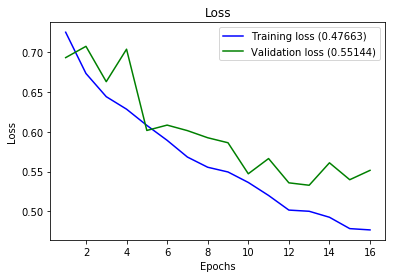

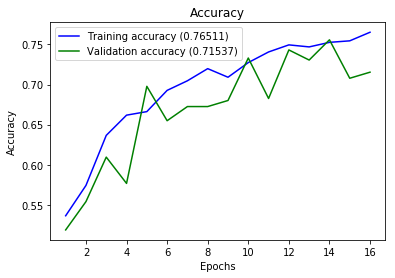

Accuracy : 0.7062374245472837

Classification Report
              precision    recall  f1-score   support

           0    0.67636   0.76543   0.71815       243
           1    0.74324   0.64961   0.69328       254

   micro avg    0.70624   0.70624   0.70624       497
   macro avg    0.70980   0.70752   0.70571       497
weighted avg    0.71054   0.70624   0.70544       497

[[186  57]
 [ 89 165]]


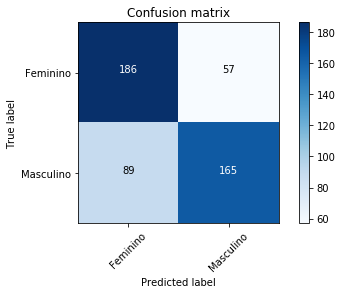

In [154]:
params = best_parameters

## create the model with the best params found
model = create_model(filters=params['filters'],
                     kernel_size=params['kernel_size'],
                     strides=params['strides'],
                     dropout_rate=params['dropout_rate'],
                     pool_size=[params['pool_size']]
                    )

## Then train it and display the results
history = model.fit(x_train,
                    y_train,
                    epochs=params['epochs'],
                    validation_split=0.2,
                    #batch_size=params['batch_size'],
                    verbose = 0,
                       callbacks=[
                           #ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01),
                           EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
                  ])

model.summary()

directory='/home/rafael/'

plot_history(history, directory=directory)

full_multiclass_report(model,
                       x_test,
                       y_test,
                       classes=classes_names,
                       directory=directory
                      )
                       #batch_size=32,
                       #binary= )
        
        
#result = result
# get_results(model, y_test, model.predict_classes(X_test))

In [90]:
y_pred = model.predict_classes(x_test)
accuracy_score(y_test, y_pred)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[19, 10,  1],
       [21, 17,  1],
       [ 5,  7, 10]])